# Fifth lecture: Julia

## Unsupervised Machine Learning: KMeans clustering algorithm

## In this notebook:
* [1. Import packages](#first-bullet)
* [2. Functions definition](#second-bullet)
* [3. Data preparation](#third-bullet)
    * [3.a Import data from CSV](#third-a-bullet)
    * [3.b Visualise the data](#third-b-bullet)
    * [3.c Preprocess the data](#third-c-bullet)
* [4. KMeans clustering](#forth-bullet)
    * [4.a Clustering analysis with a priori number of clusters](#forth-a-bullet)
    * [4.b silhouette analysis](#forth-b-bullet)
    * [4.c Clustring analysis with optimesed number of clusters](#forth-c-bullet)
* [5. Reference](#fifth-bullet)

## 1. Import packages <a class="anchor" id="first-bullet"></a>

In [1]:
using DataFrames
using Statistics
using Clustering
using GMT
using CSV
using Random
using TableTransforms
using StatsPlots

## 2. Functions definition <a class="anchor" id="second-bullet"></a>

In [2]:
function show_map(temp, colorize=false, element=false)

    #=
    Displays the Italian peninsula and geographically places markers at the positions of the data provided 
    
    Input: 
        temp: input data, needed X and Y columns for the coordinates; DataFrame
        colorize: determine single or multi-colored marker; Bool, default = false
        element: determine the colorcoding of the markers; Vector, default = false
    
    =#
    
    if (colorize == true) && (element != false)
        GMT.coast(
            region="6/36/21/48+r", 
            proj=(name=:laea, center=[10,50]), 
            frame=:ag, 
            res=:high,
            area=200, 
            shore=:thin, 
            borders=2,
        )

        GMT.scatter!(
            temp.X, temp.Y, 
            marker=:circle,
            markeredgecolor=0, 
            size=0.2, 
            color=:ocean,         
            zcolor=element,
            show=true
        )

    elseif (colorize == true) && (element == false)
        
        println("Define the element that generate the colorcoding")
        
    elseif (colorize == false) && (element == false)
        
        GMT.coast(
        region="6/36/21/48+r", 
        proj=(name=:laea, center=[10,50]), 
        frame=:ag, 
        res=:high,
        area=200, 
        shore=:thin, 
        borders=2,
        )
    
        GMT.scatter!(
        temp.X, temp.Y, 
        marker=:circle,
        markeredgecolor=0, 
        size=0.2, 
        markerfacecolor=:blue,
        show=true
        )
    end
    
end;

## 3. Data preparation <a class="anchor" id="third-bullet"></a>

### 3.a Import data from CSV <a class="anchor" id="third-a-bullet"></a>

In [3]:
cd("./Data/")
temp = CSV.File("dataR.csv") |> DataFrame
cd("..")
first(temp,10)

Row,Column1,kg_km2,X,Y,X.utm,Y.utm,month,year,depth,CHL,TMP_sst,TMP_bot,dox.bot,nit,pho,sal,poc
,Int64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,20939,7.48576,13.3848,45.1201,372.964,4997.56,7,2018,36.0,0.224064,26.0436,19.7077,239.658,0.0133787,0.0185428,38.5887,23.5374
2,21018,11.4592,13.4063,45.3648,375.192,5024.71,7,2018,26.5,0.128789,25.9431,22.9975,245.418,0.177281,0.0154124,38.6224,17.804
3,21019,10.8606,13.4351,45.1739,377.036,5003.46,7,2018,32.0,0.16948,25.9662,21.7459,237.668,0.019241,0.0149958,38.5967,23.2143
4,31558,13.6624,12.831,44.0415,326.222,4878.77,8,2018,13.5,0.191076,28.1614,28.8835,203.521,2.56201,0.036216,35.9555,23.7169
5,31723,7.45241,15.1115,42.0248,509.231,4652.54,8,2018,24.5,0.125584,28.0418,24.0994,235.759,1.15765,0.0149592,37.1873,15.128
6,32206,11.2129,14.8819,42.1196,490.238,4663.06,8,2018,21.5,0.126854,28.0866,21.3216,233.945,1.42575,0.0165692,37.1132,14.5633
7,32834,8.74539,14.4488,42.3923,454.632,4693.48,8,2018,22.5,0.0871999,27.8902,27.65,187.43,1.91921,0.0126614,36.4214,8.78484
8,32835,9.36797,14.0683,42.7909,423.801,4738.02,8,2018,17.0,0.133999,27.9537,26.1742,221.078,1.97087,0.0173337,36.3891,14.9995
9,32958,10.892,13.9429,43.2257,414.153,4786.43,8,2018,20.0,0.150982,27.8245,21.2845,241.338,1.13758,0.020106,37.3759,18.4252


### 3.b Visualise the data <a class="anchor" id="third-b-bullet"></a>

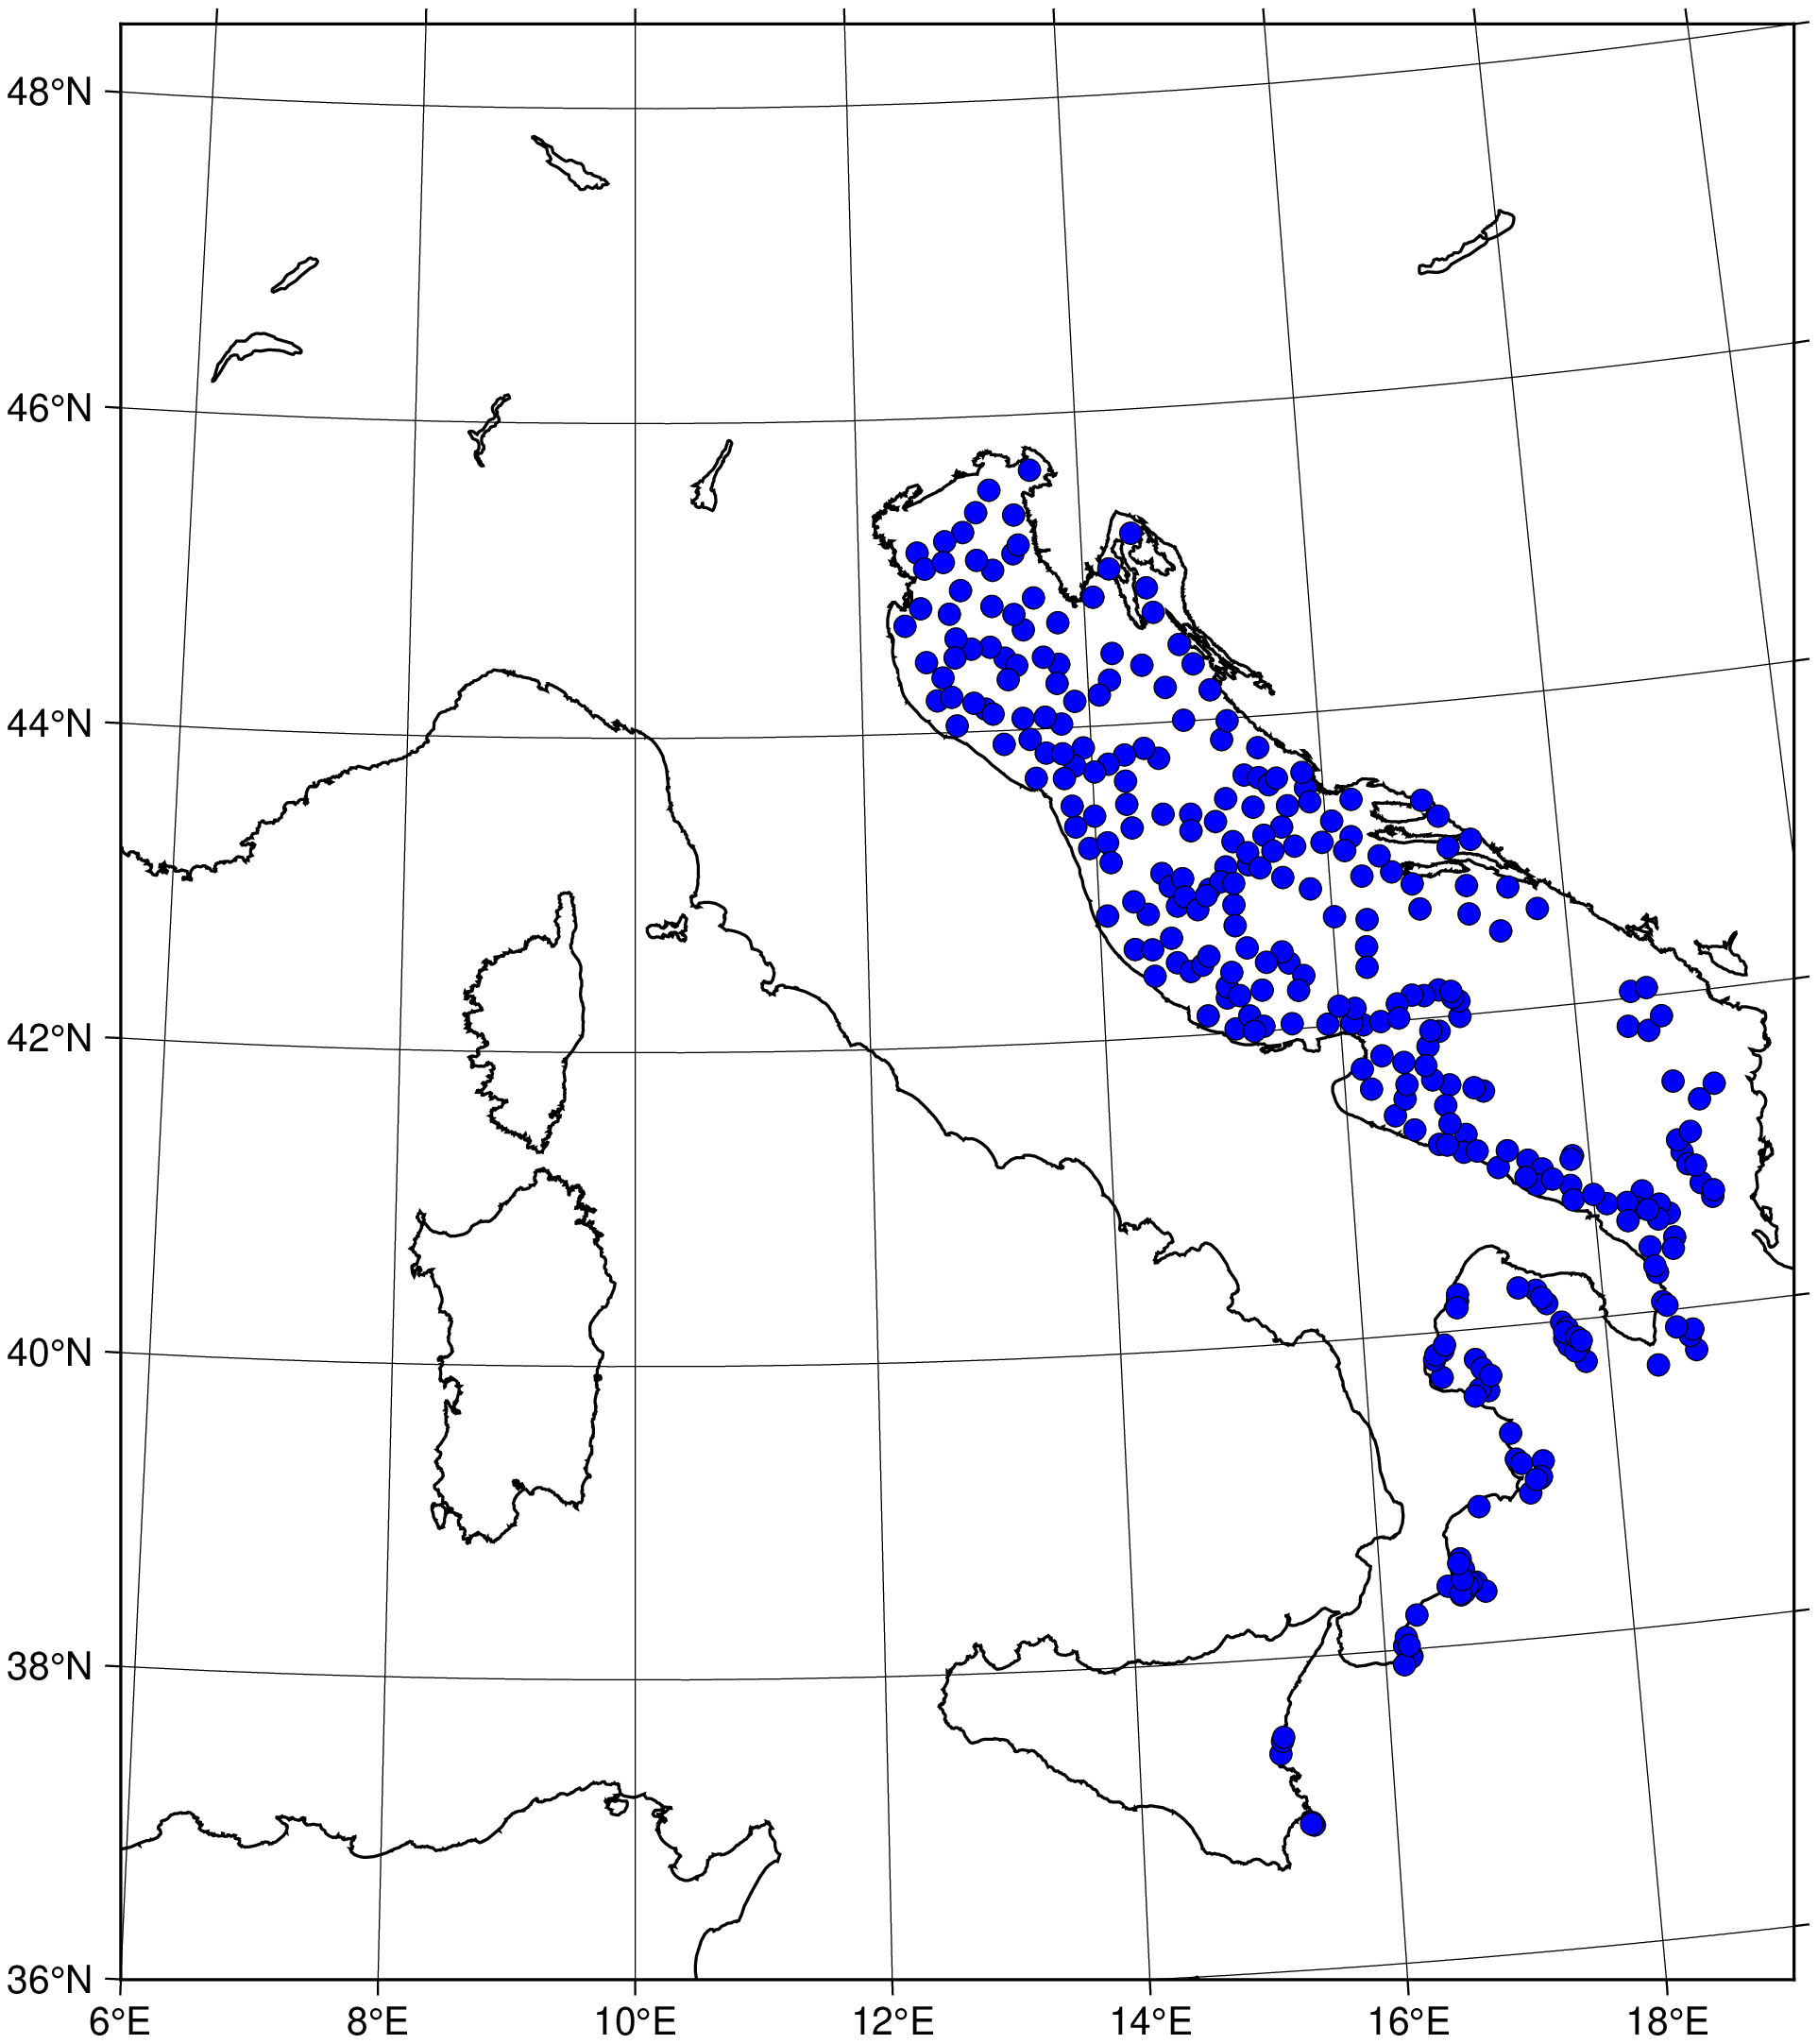

In [4]:
show_map(temp)

### 3.c Preprocess the data <a class="anchor" id="third-c-bullet"></a>

In [5]:
myvars = ["X","Y","CHL", "TMP_sst", "TMP_bot", "dox.bot", "nit", "pho", "sal", "poc"]
data = temp[!, myvars]
Zscore = TableTransforms.ZScore("TMP_sst", "TMP_bot", "dox.bot", "nit", "pho", "sal", "poc")
data = Zscore(data)
data = transpose(Matrix(data[!, Not(:X,:Y)]))

8×321 transpose(::Matrix{Float64}) with eltype Float64:
  0.224064   0.128789   0.16948   …   0.124794    0.237569     0.173425
 -0.42953   -0.499887  -0.483709      0.874992    0.717938     0.664851
  1.24116    2.21879    1.84686      -0.497583   -0.31496     -0.3919
  1.21312    1.55041    1.09662      -0.218171   -0.0195247   -0.106388
 -0.88774   -0.68764   -0.880584     -0.354232   -0.463561    -0.366198
 -1.31587   -1.40888   -1.42126   …   0.476044   -0.0525084    0.5499
  0.133372   0.199498   0.148965      0.0777717  -0.00510401   0.153226
  0.934817   0.489874   0.909744     -0.0223063   0.772887     0.345865

## 4. KMeans clustering <a class="anchor" id="forh-bullet"></a>

### 4.a Clustering analysis with a priori number of clusters <a class="anchor" id="forth-a-bullet"></a>

#### Apply the KMeans algorithm

In [6]:
Random.seed!(1234)
R = Clustering.kmeans(data, 3; init=:rand)
a = assignments(R) 
c = counts(R) 

println(">"^10," Number of elements in each cluster ","<"^10)
for i in 1:3
println("Cluster ",i," # of elements ",c[i])
end

>>>>>>>>>> Number of elements in each cluster <<<<<<<<<<
Cluster 1 # of elements 173
Cluster 2 # of elements 22
Cluster 3 # of elements 126


#### Add the KMeans assigned cluster to each observation

In [7]:
temp[!, :Cluster3] .= a
first(temp, 5)

Row,Column1,kg_km2,X,Y,X.utm,Y.utm,month,year,depth,CHL,TMP_sst,TMP_bot,dox.bot,nit,pho,sal,poc,Cluster3
,Int64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,20939,7.48576,13.3848,45.1201,372.964,4997.56,7,2018,36.0,0.224064,26.0436,19.7077,239.658,0.0133787,0.0185428,38.5887,23.5374,1
2,21018,11.4592,13.4063,45.3648,375.192,5024.71,7,2018,26.5,0.128789,25.9431,22.9975,245.418,0.177281,0.0154124,38.6224,17.804,1
3,21019,10.8606,13.4351,45.1739,377.036,5003.46,7,2018,32.0,0.16948,25.9662,21.7459,237.668,0.019241,0.0149958,38.5967,23.2143,1
4,31558,13.6624,12.831,44.0415,326.222,4878.77,8,2018,13.5,0.191076,28.1614,28.8835,203.521,2.56201,0.036216,35.9555,23.7169,2
5,31723,7.45241,15.1115,42.0248,509.231,4652.54,8,2018,24.5,0.125584,28.0418,24.0994,235.759,1.15765,0.0149592,37.1873,15.128,2


#### Visualize the data with a colorcoding given by the assigned cluster

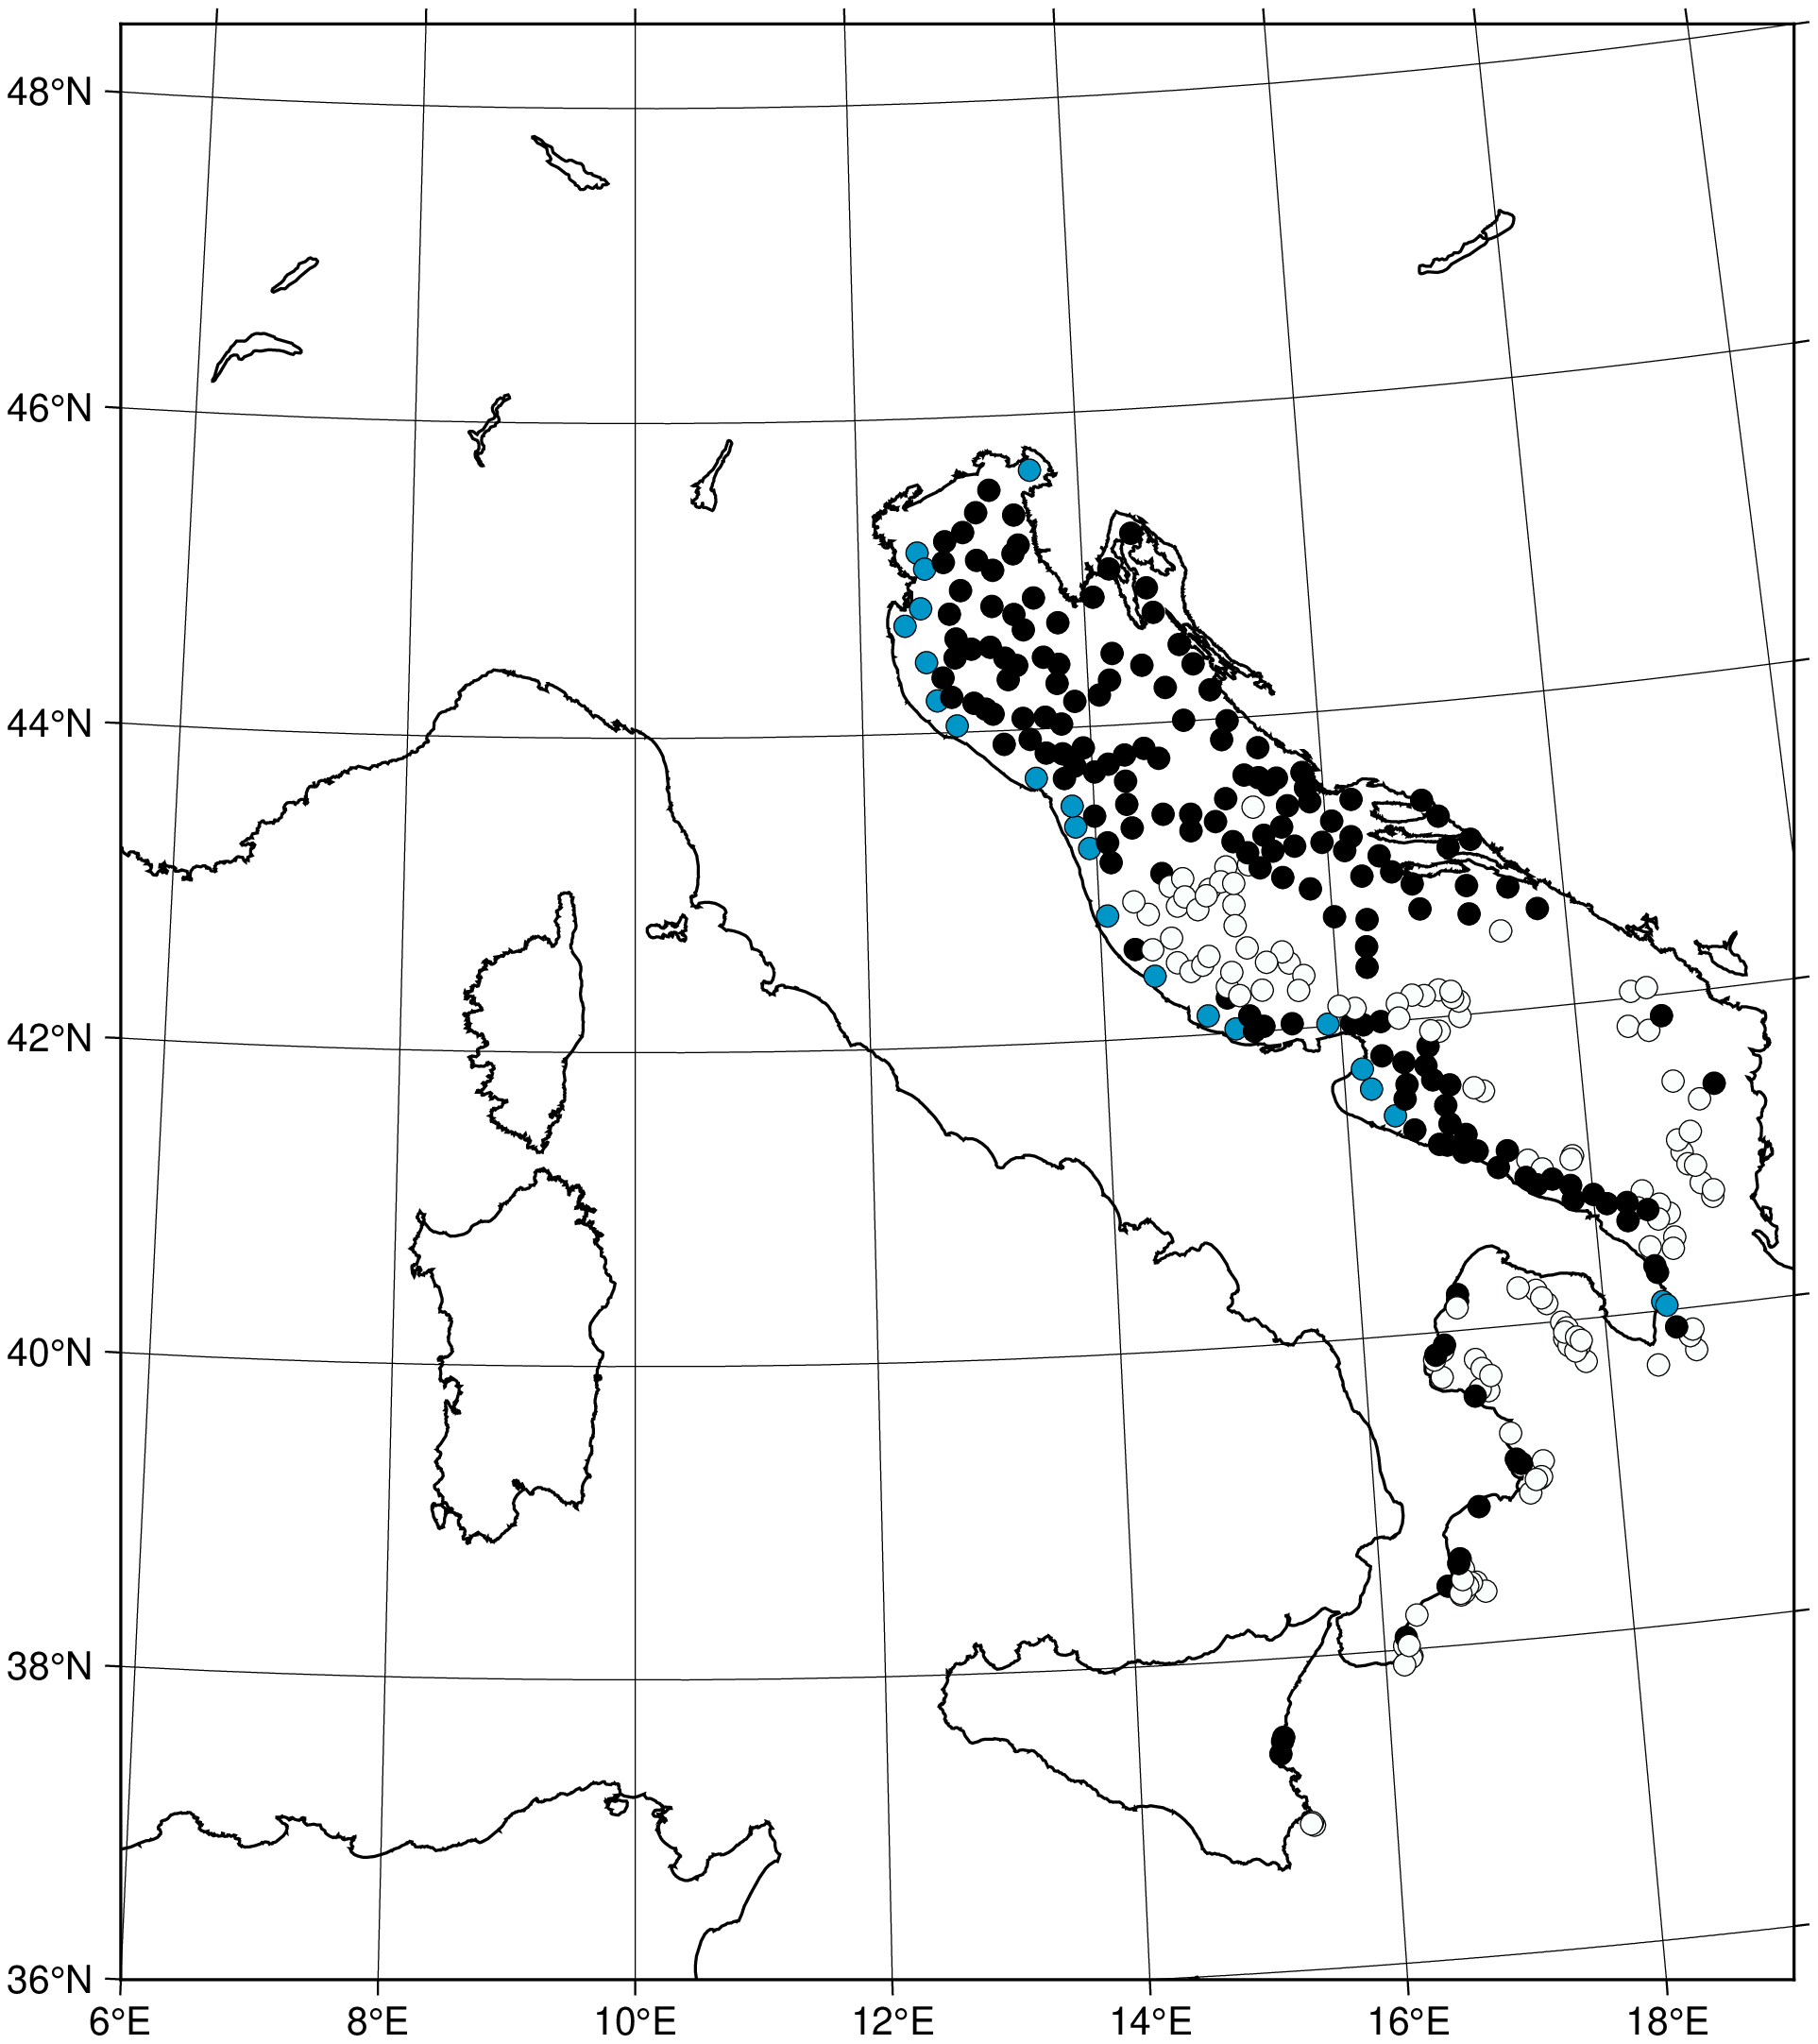

In [8]:
show_map(temp,true,temp[!,:Cluster3])

### 4.b silhouette analysis <a class="anchor" id="forth-b-bullet"></a>

#### Compute the silhouette score with different number of clusters

In [9]:
silh_vec = Vector{Float32}()
for nclus in 3:13
    Random.seed!(1234)
    R = Clustering.kmeans(data, nclus; init=:rand)
    centr = R.centers
    ass = R.assignments
    append!(silh_vec,Clustering.clustering_quality(data, centr, ass; quality_index = :silhouettes))
end

#### Plot the silhouette scores

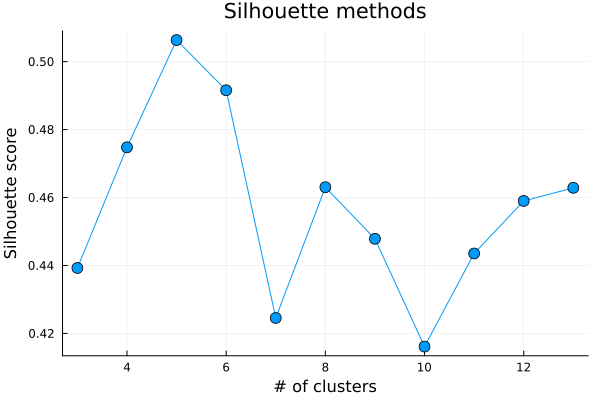

In [10]:
Plots.plot(3:13,silh_vec,
            marker = :circle, markersize = 6,
            line = true, 
            title = "Silhouette methods", 
            xlabel = "# of clusters", ylabel = "Silhouette score", 
            label = false
            )

### 4.c Clustring analysis with optimesed number of clusters <a class="anchor" id="forth-c-bullet"></a>

#### Apply the KMeans algorithm

In [11]:
Random.seed!(1234)
optimal_nclus = 5
R = Clustering.kmeans(data, optimal_nclus; init=:rand)
a = assignments(R) 
c = counts(R) 

println(">"^10," Number of elements in each cluster ","<"^10)
for i in 1:optimal_nclus
println("Cluster ",i," # of elements ",c[i])
end

>>>>>>>>>> Number of elements in each cluster <<<<<<<<<<
Cluster 1 # of elements 85
Cluster 2 # of elements 20
Cluster 3 # of elements 116
Cluster 4 # of elements 1
Cluster 5 # of elements 99


#### Add the new KMeans assigned cluster to each observation

In [12]:
temp[!, :ClusterOptimalKmeans] .= a
first(temp, 5)

Row,Column1,kg_km2,X,Y,X.utm,Y.utm,month,year,depth,CHL,TMP_sst,TMP_bot,dox.bot,nit,pho,sal,poc,Cluster3,ClusterOptimalKmeans
,Int64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64
1,20939,7.48576,13.3848,45.1201,372.964,4997.56,7,2018,36.0,0.224064,26.0436,19.7077,239.658,0.0133787,0.0185428,38.5887,23.5374,1,5
2,21018,11.4592,13.4063,45.3648,375.192,5024.71,7,2018,26.5,0.128789,25.9431,22.9975,245.418,0.177281,0.0154124,38.6224,17.804,1,5
3,21019,10.8606,13.4351,45.1739,377.036,5003.46,7,2018,32.0,0.16948,25.9662,21.7459,237.668,0.019241,0.0149958,38.5967,23.2143,1,5
4,31558,13.6624,12.831,44.0415,326.222,4878.77,8,2018,13.5,0.191076,28.1614,28.8835,203.521,2.56201,0.036216,35.9555,23.7169,2,2
5,31723,7.45241,15.1115,42.0248,509.231,4652.54,8,2018,24.5,0.125584,28.0418,24.0994,235.759,1.15765,0.0149592,37.1873,15.128,2,2


#### Visualize the data with a colorcoding given by the new assigned cluster

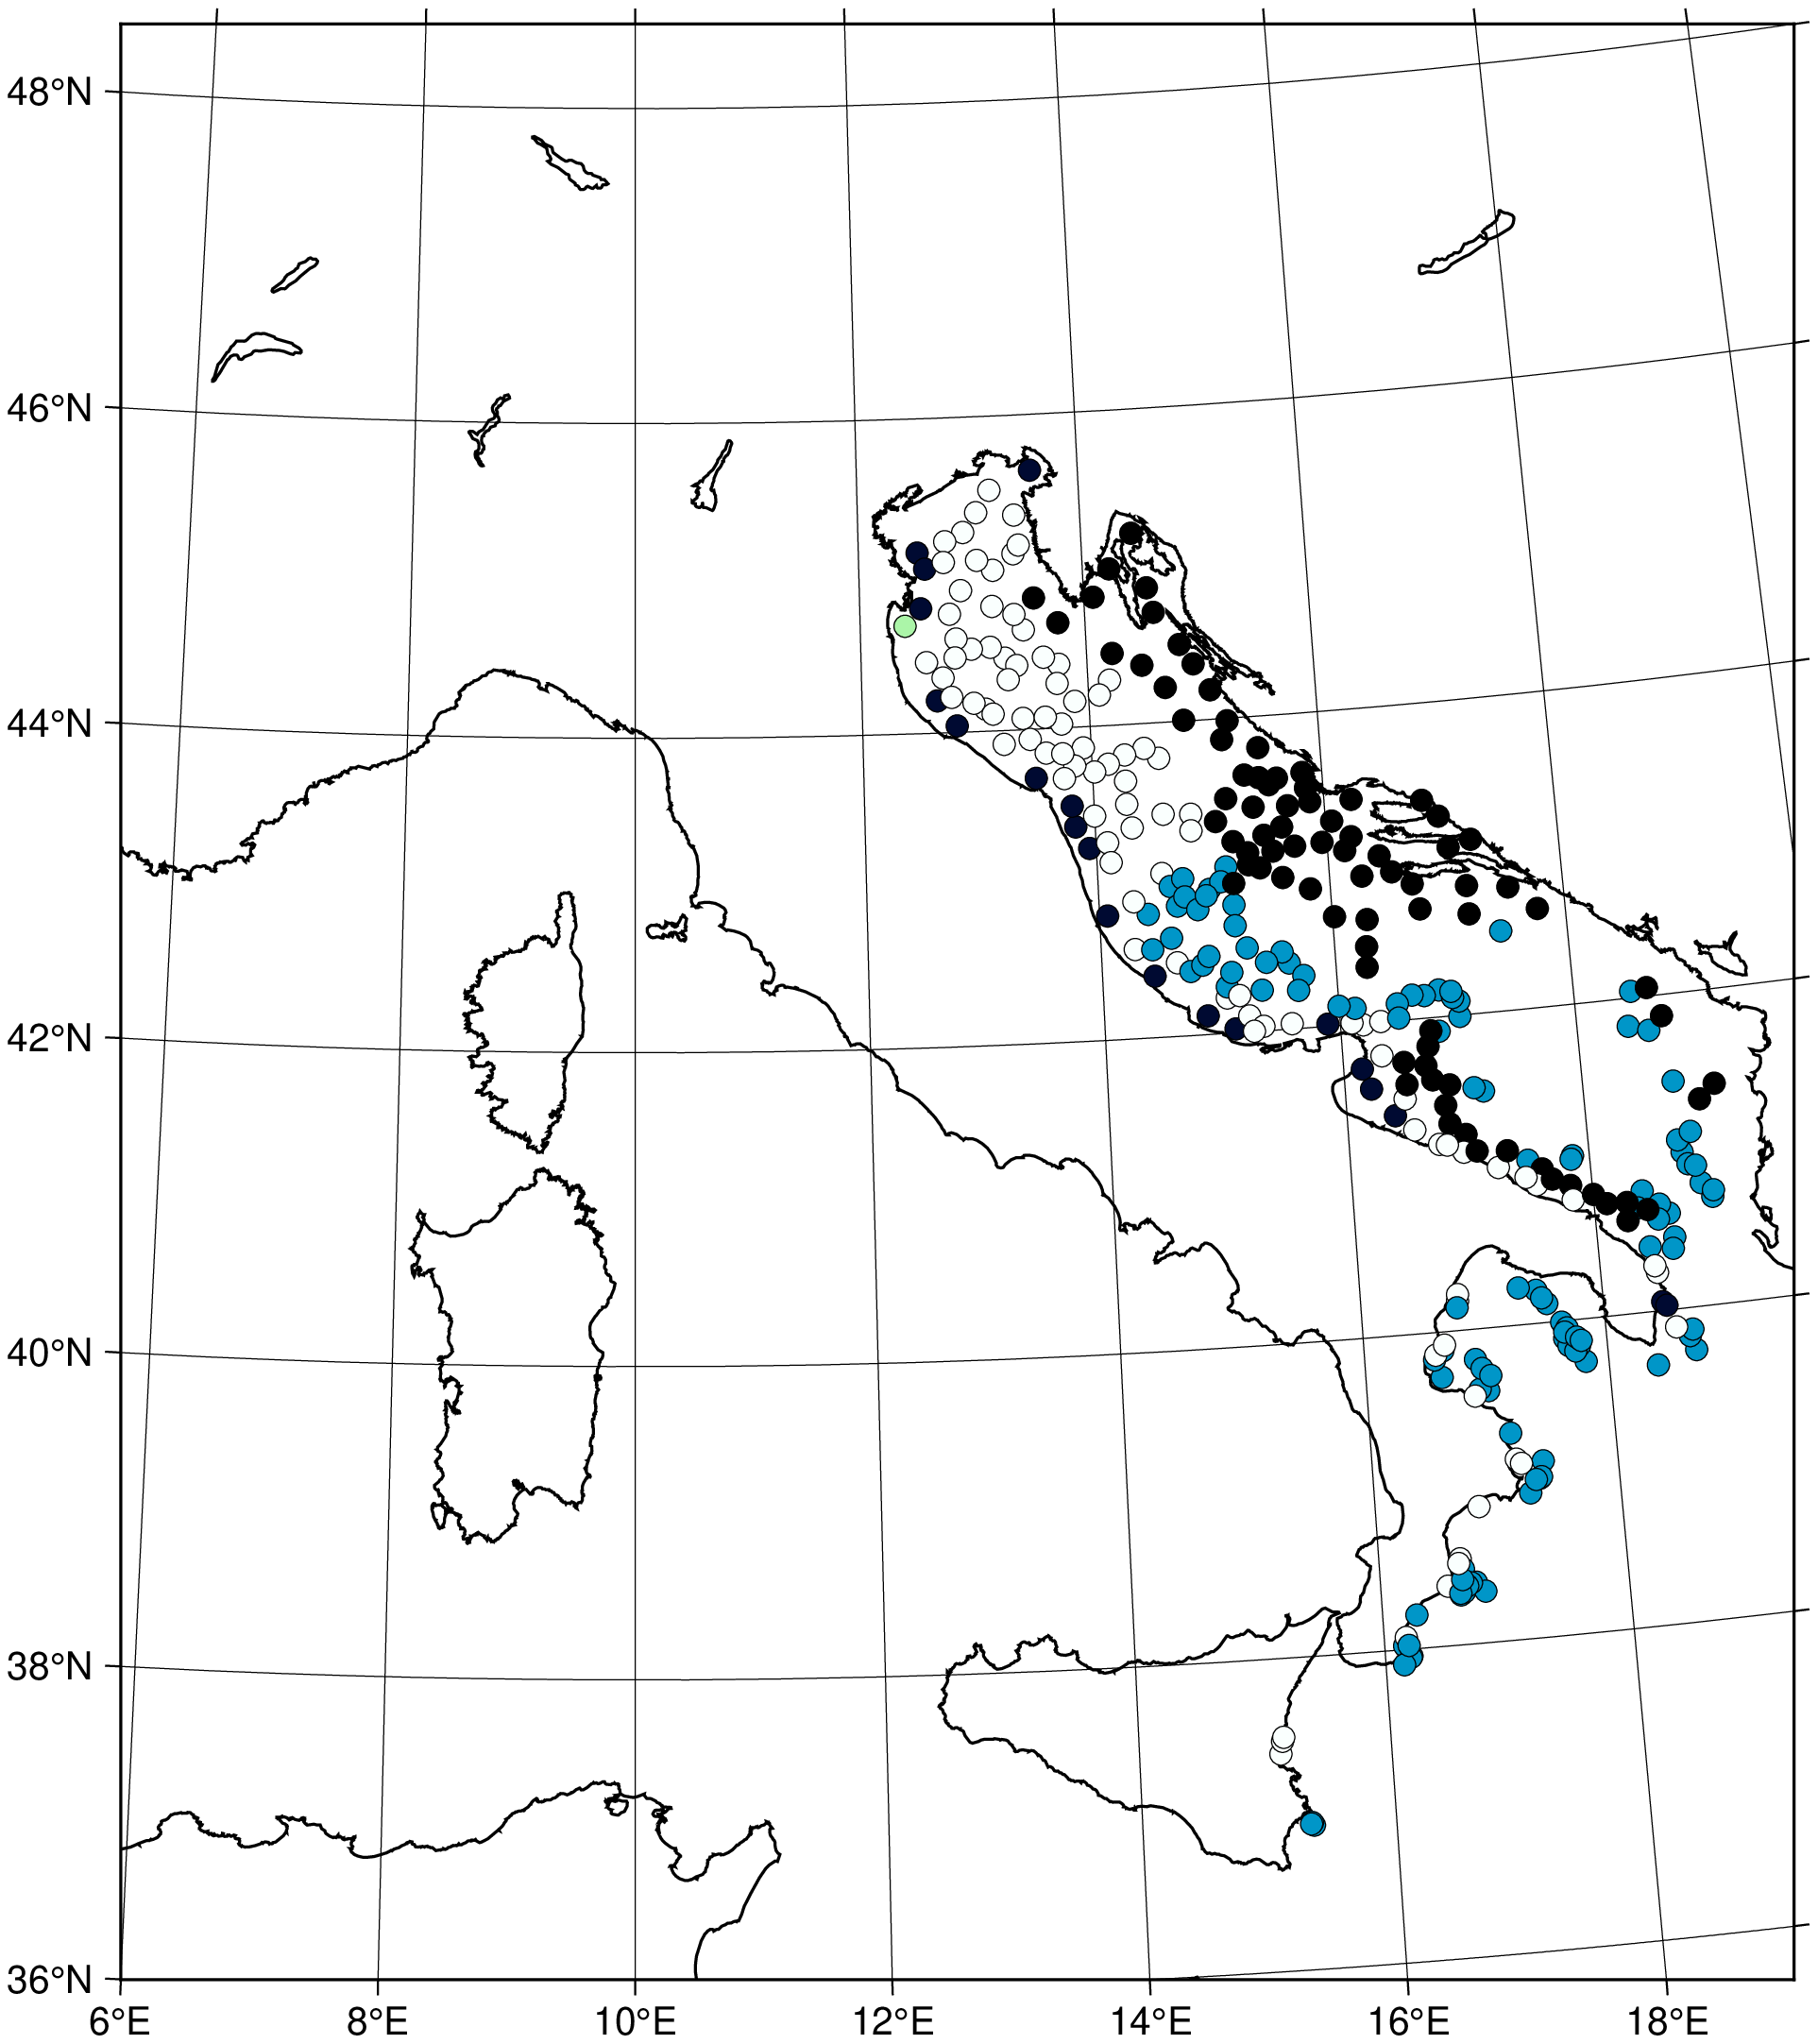

In [13]:
show_map(temp,true,temp[!,:ClusterOptimalKmeans])

#### Generate some boxplots, grouped by new KMeans clusters assignement

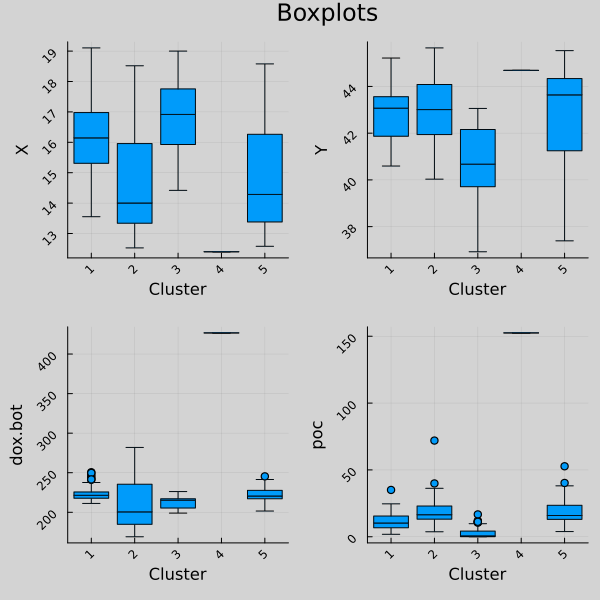

In [14]:
l = @layout [a b ; c d] 
gr(size=(600,600), bg = :lightgrey)

p1 = @df temp StatsPlots.boxplot(:ClusterOptimalKmeans, :X, ylabel="X")
p2 = @df temp StatsPlots.boxplot(:ClusterOptimalKmeans, :Y, ylabel="Y")
p3 = @df temp StatsPlots.boxplot(:ClusterOptimalKmeans, temp[!, "dox.bot"], ylabel="dox.bot")
p4 = @df temp StatsPlots.boxplot(:ClusterOptimalKmeans, :poc, xlabel="Cluster", ylabel="poc")

Plots.plot(p1, p2, p3, p4, layout = l, plot_title="Boxplots", xlabel="Cluster", rotation=45, legend=false)

## 5. References <a class="anchor" id="fifth-bullet"></a>

1. **An Introduction to Statistical Learning** – *Gareth James , Daniela Witten , Trevor Hastie , Robert Tibshirani and Jonathan Taylor*
2. **The Elements of Statistical Learning** – *T.Hastie, R. Tibshirani and J.H. Friedman*
3. **Analisi dei dati e Data Mining** – *A. Azzalini e B. Scarpa*